<a href="https://colab.research.google.com/github/alexandster/anti-Asian-BERT/blob/main/BERT_anti_Asian_fine_tune_bert_NLPaug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
pip install transformers

In [32]:
pip install nlpaug


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 33.1 MB/s 


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
import tensorflow as tf
import pandas as pd
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load dataset - labels 0: not hateful, 1: hateful

In [5]:
import numpy as np
df = pd.read_excel('/content/drive/MyDrive/Research Projects/AAPI2/data/combined_v2.xlsx').sample(frac=1,random_state=0)
df.head()



,ID,Tweet ID,Text,label01,Source
24708,24709,1.304248e+18,"Good read and great reporting, as usual, from ...",0,AL
19760,19761,1.239712e+18,@eugenegu @realdonaldtrump #chinesevirus is tr...,0,Studies
27137,27138,3.133488e+09,So @realDonaldTrump sent tons of our PPE to Ch...,0,DH
2396,2397,1.214193e+18,@coffee_ted They are more like terrorists. #Po...,0,Studies
25904,25905,1.250981e+18,Quarantine got me thinking about being a veget...,0,AY


In [60]:
df['Text'] = [re.sub(r'http\S+', '', i) for i in df['Text']]

In [61]:
#convert label to integer
df = df.astype({"label01": int})
df.dtypes
df.head()

,ID,Tweet ID,Text,label01,Source
24708,24709,1.304248e+18,"Good read and great reporting, as usual, from ...",0,AL
19760,19761,1.239712e+18,@eugenegu @realdonaldtrump #chinesevirus is tr...,0,Studies
27137,27138,3.133488e+09,So @realDonaldTrump sent tons of our PPE to Ch...,0,DH
2396,2397,1.214193e+18,@coffee_ted They are more like terrorists. #Po...,0,Studies
25904,25905,1.250981e+18,Quarantine got me thinking about being a veget...,0,AY


In [62]:
df.shape

(27290, 5)

In [63]:
# check class distribution
df['label01'].value_counts(normalize = True)

0    0.806303
1    0.193697
Name: label01, dtype: float64

In [125]:
#class balancing
aug = naw.SynonymAug(aug_src = 'wordnet', aug_min = 3)

# test_sentences = list(df1['Text'])[:5]
# print(test_sentences[:2])

# out_sentences = aug.augment(test_sentences)
# print(out_sentences[:2])



#extract hateful tweets
df1 = df[df['label01'] == 1]

#copy of df1
dfc = df1

#augment tweets
synonyms = aug.augment(list(df1['Text']))

dfc['Text'] = synonyms

#stitch together again
df2 = pd.concat([df, dfc])

# df2 = pd.concat([df, df1, df1, df1])
df2['label01'].value_counts(normalize = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    0.675467
1    0.324533
Name: label01, dtype: float64

In [154]:
#split into train and test sets
from sklearn.model_selection import train_test_split

#train: training set for model building, val: validation set for hyperparameter tuning, test: test set for model evaluation
#initial split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label01'], test_size=0.1, random_state=1)

#add synthetic data to training set
X_train = pd.concat([X_train, pd.DataFrame(synonyms)]).reset_index(drop=True)
y_train = pd.concat([y_train, df1['label01']]).reset_index(drop=True)

#text/val split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [155]:
#merge text with labels train
train = pd.concat([X_train, y_train], axis=1)
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,rt @marvintsk: @donaldjtrumpjr fuck #china an...,1
1,RT @ArthurKent Of course the president-for-lif...,0
2,"In Pictures: Coronavirus epicentre city, Wuhan...",0
3,@who we are eight weeks into this #covid19 out...,1
4,â€œYouâ€™re a loser.â€ â€œIâ€™m the #Winner!â...,0


In [156]:
#merge text with labels test
val = pd.concat([X_val, y_val], axis=1)
val.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
val.head()

,DATA_COLUMN,LABEL_COLUMN
9390,"RT @HealthUpdates5 Share this, China trying to...",0
23275,The Album of Quarantine 2020. @mavisstaples #W...,0
19741,whatâ€™s taking china so long to apologize to ...,0
4600,Last update: 2020/1/28 17:20 â€¢ Death toll: 1...,0
17850,"a racist, homophobe &amp; a failed doofus poli...",0


In [157]:
#how many train and test samples?
print(train.shape)
print(val.shape)

(29847, 2)
(1365, 2)


# Find class weights

In [158]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train['LABEL_COLUMN']), 
    y = train_labels)

print(class_wts)

[0.6201263  2.58114297]


In [159]:
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 1

In [160]:
#data structure
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [161]:
#define function to convert data to examples
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

#define function to convert examples to tensorflow dataset  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
#call functions
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [163]:
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

#fit model
history = model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
1866/1866 [==============================] - 1879s 994ms/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 3.3712 - val_accuracy: 0.2733
Epoch 2/2
1866/1866 [==============================] - 1501s 804ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 2.2070 - val_accuracy: 0.5824


# Model diagnostics

In [164]:
#precision, recall, f1-score
from sklearn.metrics import classification_report
preds=model.predict(validation_data)
preds=np.argmax(preds.logits, axis=1)
print(classification_report(temp_labels, preds))

              precision    recall  f1-score   support

           0       0.82      0.39      0.53      1101
           1       0.20      0.65      0.31       264

    accuracy                           0.44      1365
   macro avg       0.51      0.52      0.42      1365
weighted avg       0.70      0.44      0.49      1365



In [165]:
#confusion matrix
pd.crosstab(temp_labels, preds)

col_0,0,1
label01,,
0,432,669
1,92,172


In [166]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(temp_labels, preds)

0.4424908424908425

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


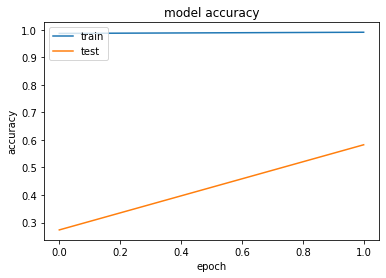

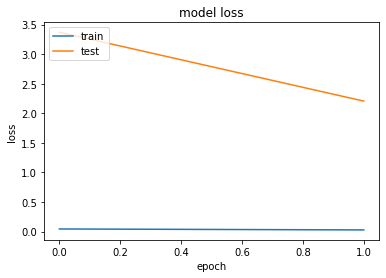

In [167]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#save model
# import torch
# model.save_pretrained('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedbertmodel2/')
# tokenizer.save_pretrained('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/')






('/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/tokenizer_config.json',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/special_tokens_map.json',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/vocab.txt',
 '/content/drive/MyDrive/Research Projects/AAPI2/data/trainedberttokenizer2/added_tokens.json')

In [ ]:
#end